In [1]:
import os
import sys
import inspect

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.backends.backend_pdf import PdfPages
from ipywidgets import interact, IntSlider, fixed
from scipy.optimize import curve_fit

In [2]:
pixel_size = 6.45 # mkm
test_obj_mkm_size = 150 # mkm
test_obj_pix_size = 66 # pix
wavelength = 0.8 # mkm
magnification = test_obj_pix_size * pixel_size / test_obj_mkm_size
print('magnification =', magnification)
mkm_per_pixel = pixel_size / magnification
print('mkm_per_pixel =', mkm_per_pixel)

magnification = 2.838
mkm_per_pixel = 2.272727272727273


In [3]:
IN_FOLDER = './data_to_prepare/'
OUT_FOLDER = './prepared_data/'
back_name = 'bg.tif'
int_name = 'fil.tif'

delay_folder = input('delay_folder: ')

IN_PATH = os.path.join(IN_FOLDER, delay_folder)
OUT_PATH = os.path.join(OUT_FOLDER, delay_folder)

BASE_PATH_FIL = os.path.join(IN_PATH, 'fil/')
BASE_PATH_BACK = os.path.join(IN_PATH, 'bg/')

if not os.path.exists(BASE_PATH_FIL):
    print(f"something went wrong with path {BASE_PATH_FIL}")
    
if not os.path.exists(BASE_PATH_BACK):
    print(f"something went wrong with path {BASE_PATH_BACK}")

if not os.path.exists(OUT_FOLDER):
    os.mkdir(OUT_FOLDER)

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

delay_folder: f50_stoch_11_5cm


In [4]:
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
print(f"{parent_dir} was added to sys.path")

/Users/g.gospodinov/Desktop/IntTool was added to sys.path


In [5]:
from IntTool.utils import *

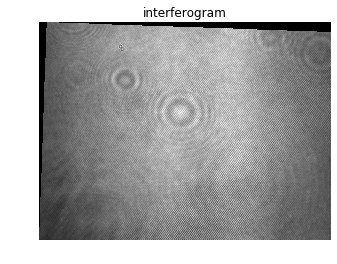

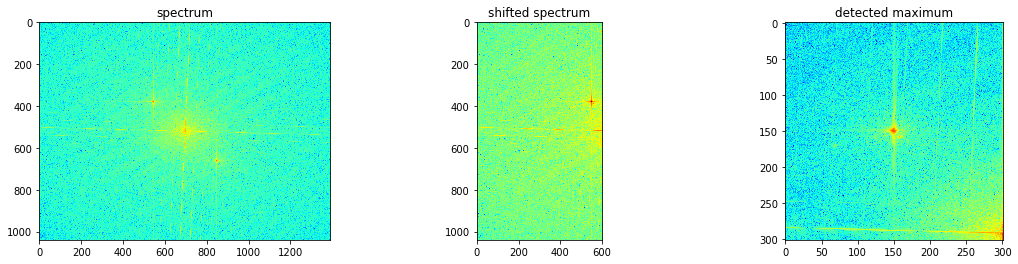

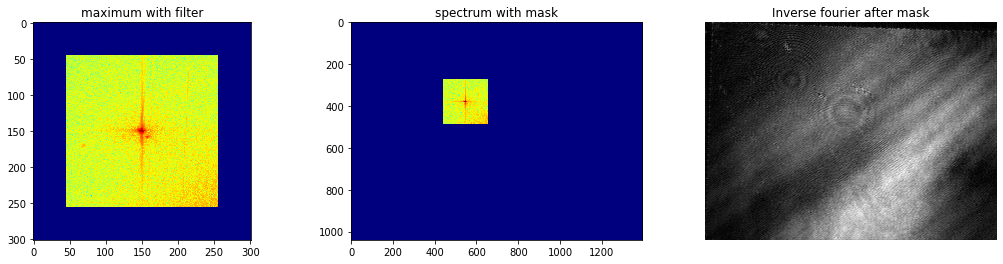

In [6]:
interferogram = read_image(os.path.join(IN_PATH, int_name))
background = read_image(os.path.join(IN_PATH, back_name))

crop = [0, interferogram.shape[0], 0, interferogram.shape[1]]
angle = 358

interferogram = rotate_image(interferogram, angle, *crop)
background = rotate_image(background, angle, *crop)

mask_size = (105, 105)
area_to_show = (150, 150)
gauss_mask = False

mask_center = interferogram_describe(interferogram, mask_size, area_to_show, gauss_mask=gauss_mask, shift_x=600, shift_y=1200)

In [7]:
mask = []
x = np.arange(interferogram.shape[1])
y = np.arange(interferogram.shape[0])

@interact(img=fixed(interferogram),
          x1 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=True, value=700),
          x2 = IntSlider(min=x[0], max=x[-1], step=10, continuous_update=True, value=900),
          y1 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=True, value=600 + 50),
          y2 = IntSlider(min=y[0], max=y[-1], step=10, continuous_update=True, value=900 + 50),
          color=fixed('red')
         )
def search_mask(img, x1, x2, y1, y2, color):
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray')
    plt.plot([x1, x1], [0, img.shape[0] - 1], color)
    plt.plot([x2, x2], [0, img.shape[0] - 1], color)
    plt.plot([0, img.shape[1] - 1], [y1, y1], color)
    plt.plot([0, img.shape[1] - 1], [y2, y2], color)
    plt.savefig(os.path.join(OUT_PATH,'./crop_position_{}.png'.format(delay_folder)))
    plt.show()
    Intensity = complex_abs(
        inverse_fourier(
            apply_mask(fourier(interferogram), mask_center, mask_size, gauss=gauss_mask)
        )
    )
    plt.figure(figsize=(20, 10))
    plt.imshow(Intensity, cmap='gray')
    plt.plot([x1, x1], [0, Intensity.shape[0] - 1], color)
    plt.plot([x2, x2], [0, Intensity.shape[0] - 1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y1, y1], color)
    plt.plot([0, Intensity.shape[1] - 1], [y2, y2], color)
    plt.show()
    global mask
    mask = [y1, y2, x1, x2]

interactive(children=(IntSlider(value=700, description='x1', max=1391, step=10), IntSlider(value=900, descript…

In [8]:
def process(mask, mask_center, mask_size, angle, crop, BASE_PATH_FIL, BASE_PATH_BACK, OUT_PATH,
            up_border, down_border, border_color='black', mask_gauss=True, fil_count=5, back_count=5, remove=False):
    """
    search best background for given filament interferogram
    """
    y1,y2,x1,x2 = mask

    backs = os.listdir(BASE_PATH_BACK)
    fils = os.listdir(BASE_PATH_FIL)[::-1]
    
    if fil_count == -1:
        fil_count = len(fils)
        
    if back_count == -1:
        back_count = len(backs)
    
    max_phase = []
    
    processed = {}
    
    for fil_id in tqdm_notebook(range(fil_count)):
        min_mse = 1e5
        best_back = ''
        fil_path = os.path.join(BASE_PATH_FIL, fils[fil_id])
        interferogram = rotate_image(read_image(fil_path), angle, *crop)
        for i, back in enumerate(backs[:back_count]):
            back_path = os.path.join(BASE_PATH_BACK, back)
            background = rotate_image(read_image(back_path), angle, *crop)
            reconstructed_phase = phase_from_plasma_background(
                interferogram,
                background,
                mask,
                mask_center,
                mask_size,
                mask_gauss=mask_gauss,
                remove=remove,
                unwrap=True
            )
            max_phase.append(remove_linear_trend(reconstructed_phase.mean(1)).max())
            
            if i == 0:
                plt.imshow(reconstructed_phase, cmap='jet')
                plt.plot(
                    [0, reconstructed_phase.shape[1] - 1],
                    [up_border, up_border], 
                    border_color
                )
                plt.plot(
                    [0, reconstructed_phase.shape[1] - 1],
                    [reconstructed_phase.shape[0] + down_border, reconstructed_phase.shape[0] + down_border],
                    border_color
                )
                plt.show()
            
            mse = np.vstack((
                reconstructed_phase[down_border:] ** 2,
                reconstructed_phase[:up_border] ** 2
            )).mean()
            if mse < min_mse:
                min_mse = mse
                best_back = back
        
        back_path = os.path.join(BASE_PATH_BACK, best_back)
        background = rotate_image(read_image(back_path), angle, *crop)
        reconstructed_phase = phase_from_plasma_background(
            interferogram,
            background,
            mask,
            mask_center,
            mask_size,
            mask_gauss=mask_gauss,
            remove=remove,
            unwrap=True
        )
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.imshow(
            reconstructed_phase, 
            cmap='jet', 
            extent=(0, reconstructed_phase.shape[1] * mkm_per_pixel, 0, reconstructed_phase.shape[0] * mkm_per_pixel)
        )
        plt.colorbar()
        plt.xlabel('z, мкм', fontsize=12)
        plt.ylabel('r, мкм', fontsize=12)
        plt.subplot(122)
        x = np.arange(reconstructed_phase.shape[0])
        x = (x - x.size/2) * mkm_per_pixel
        plt.plot(x, remove_linear_trend(reconstructed_phase.mean(1)))
        plt.grid()
        plt.savefig(os.path.join(OUT_PATH, os.path.splitext(fil_path.split('/')[-1])[0] + '.png'), dpi=100)
        plt.show()
        processed[fil_path] = reconstructed_phase
    return max_phase, processed

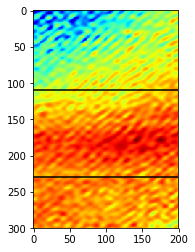

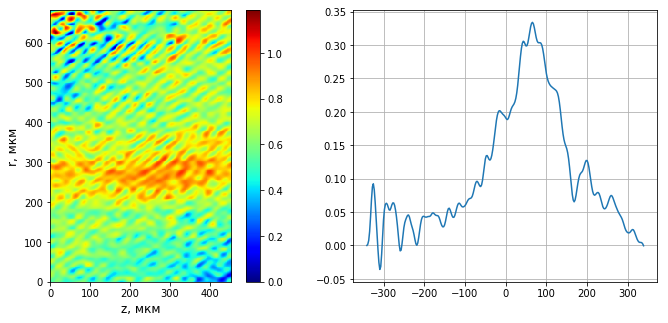

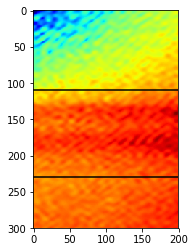

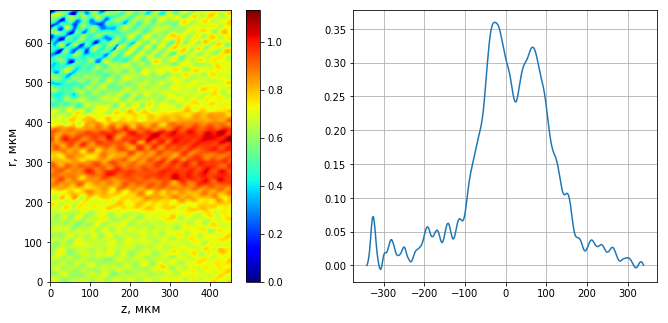

In [9]:
_, processed = process(mask, mask_center, mask_size, angle, crop, BASE_PATH_FIL, BASE_PATH_BACK, OUT_PATH,
    up_border=110, down_border=-70, mask_gauss=gauss_mask, back_count=-1, fil_count=2, remove=False)

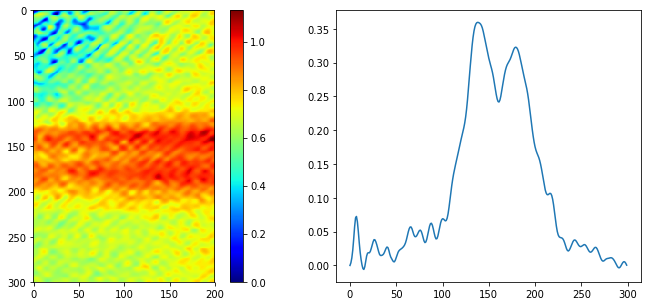

In [10]:
processed_names = list(processed.keys())

reconstructed_phase = processed[processed_names[1]]

avg_phase = remove_linear_trend(reconstructed_phase.mean(1))


plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(reconstructed_phase, cmap='jet')
plt.colorbar()

plt.subplot(122)
plt.plot(avg_phase)
plt.show()

r_2: 0.9519171231023288


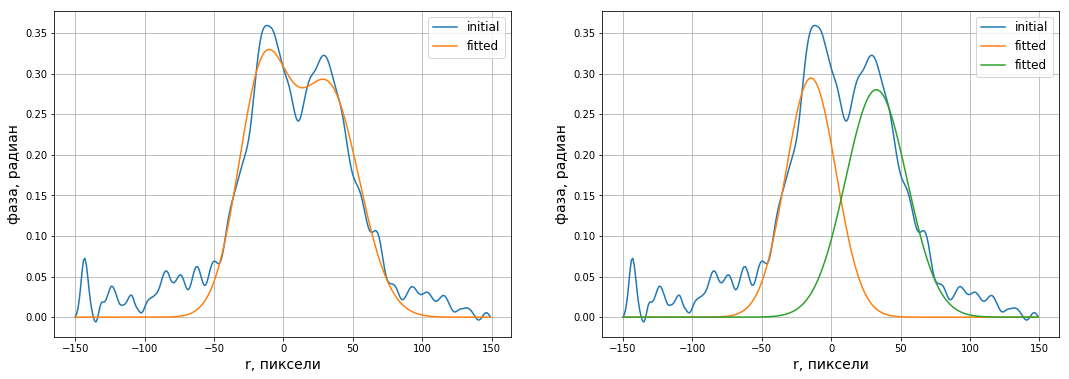

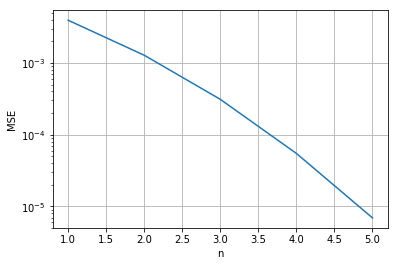

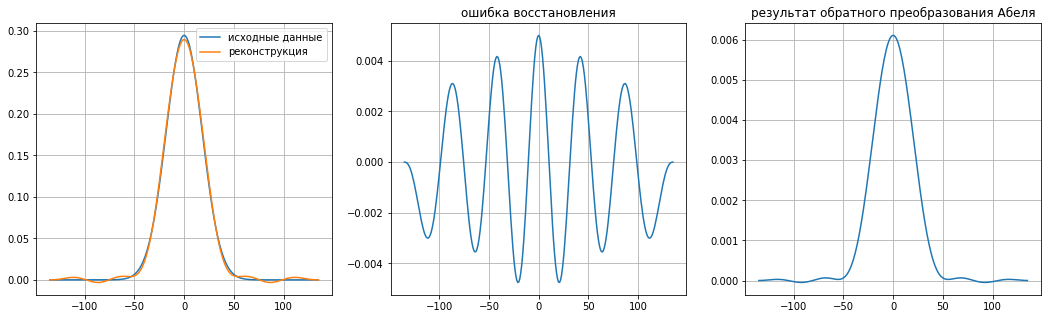

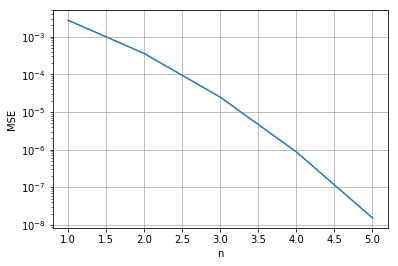

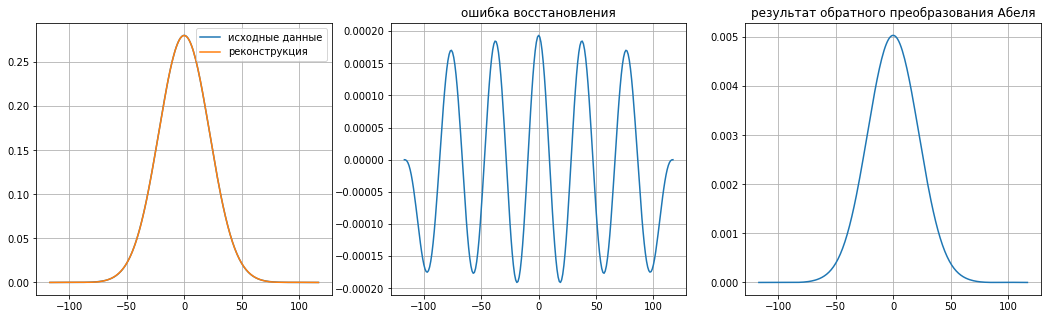

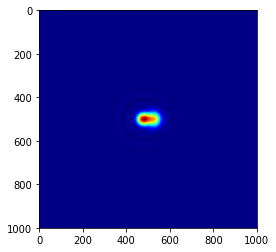

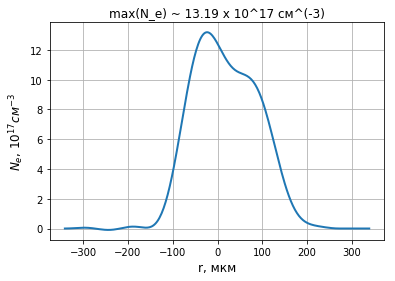

In [11]:
f_r = two_gauss_abel_inversion(avg_phase, n_max=5, p0=[-35, 0.35, 1, 35, 0.35, 1], verbose=True)
Ne = (1 - (1 - f_r * wavelength / (2 * np.pi * mkm_per_pixel))**2) * critical_density(wavelength) / 1e17
x = mkm_per_pixel * (np.arange(Ne.size) - Ne.size/2)
plt.plot(x, Ne, linewidth=2)
plt.grid()
plt.xlabel('r, мкм', fontsize=12)
plt.ylabel(r'$N_e$' + ', ' + r'$10^{17} см^{-3}$', fontsize=12)
plt.title(f"max(N_e) ~ {Ne.max():.4} x 10^17 см^(-3)")
plt.show()

In [12]:
def fit_phase(x, x0, a, b, n):
    return a * np.exp(- abs(x - x0) ** n / abs(b) ** n)

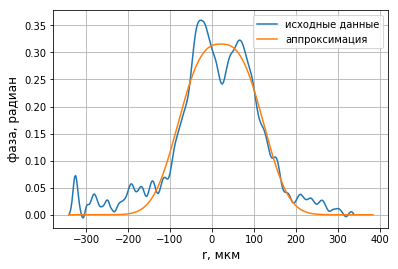

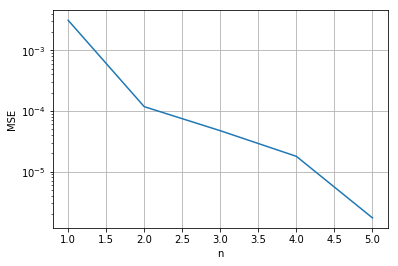

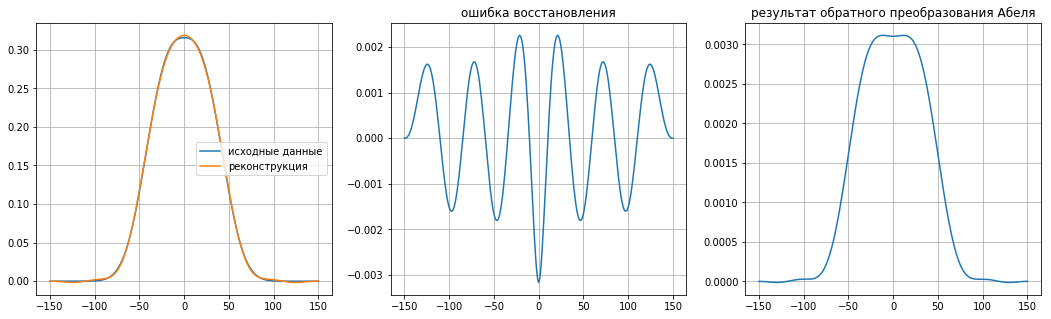

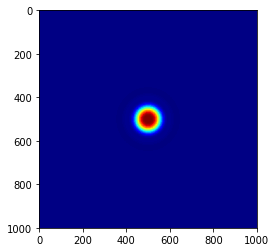

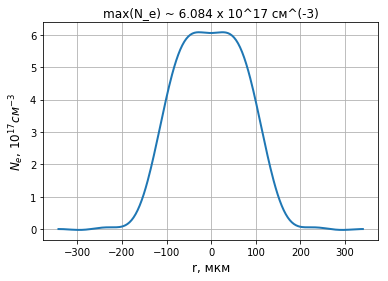

In [13]:
y = avg_phase
x_data = np.arange(y.size) - y.size / 2
popt, pcov = curve_fit(fit_phase, x_data, y, p0=[0, 0.1, 100, 2])
fit_x = np.linspace(popt[0] - 3 * abs(popt[2]), popt[0] + 3 * abs(popt[2]), num=(y.size + (y.size - 1) % 2))
fitted_phase = fit_phase(fit_x, *popt)

plt.plot(x_data * mkm_per_pixel, y, label='исходные данные')
plt.plot(fit_x * mkm_per_pixel, fitted_phase, label='аппроксимация')
plt.ylabel('фаза, радиан', fontsize=12)
plt.xlabel('r, мкм', fontsize=12)
plt.legend()
plt.grid()
plt.show()

H_y, f_r = abel_inversion(fitted_phase, n_max=5, verbose=True)
Ne = (1 - (1 - f_r * wavelength / (2 * np.pi * mkm_per_pixel))**2) * critical_density(wavelength) / 1e17

plt.imshow(phi_rotate(Ne[Ne.size//2:], size=1000), cmap='jet')
plt.show()

x = mkm_per_pixel * (np.arange(Ne.size) - Ne.size/2)
plt.plot(x, Ne, linewidth=2)
plt.grid()
plt.xlabel('r, мкм', fontsize=12)
plt.ylabel(r'$N_e$' + ', ' + r'$10^{17} см^{-3}$', fontsize=12)
plt.title(f"max(N_e) ~ {Ne.max():.4} x 10^17 см^(-3)")
plt.show()